In [67]:
import pandas as pd
import numpy as np
import pymc3
import matplotlib.pyplot as plt
import pymc3 as pm
import collections
import matplotlib.pyplot as plt
import numpy as np
import zipfile

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [68]:
pd.options.display.max_rows = 999

In [4]:
with zipfile.ZipFile('data/globalterrorismdb_0617dist.csv.zip', 'r') as f:
    f.extractall('data/')

# Part One : The EDA

### Load and clean the data

In [69]:
# load data
df = pd.read_csv('terrorism_null_filled.csv')

df.drop('Unnamed: 0', axis=1, inplace=True)

df.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (5,7,32,34,54,62,63,64,77,80,91,93,95,97,115,116,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
# check data
df.shape

(170350, 135)

In [73]:
df.isnull().sum()

eventid                    0
iyear                      0
imonth                     0
iday                       0
approxdate            162886
extended                   0
resolution            168131
country                    0
country_txt                0
region                     0
region_txt                 0
provstate              14502
city                     446
latitude                   6
longitude                  6
specificity                4
vicinity                   0
location              122376
summary                66138
crit1                      0
crit2                      0
crit3                      0
doubtterr                  0
alternative           143719
alternative_txt       143719
multiple                   0
success                    0
suicide                    0
attacktype1                0
attacktype1_txt            0
attacktype2           164720
attacktype2_txt       164720
attacktype3           169976
attacktype3_txt       169976
targtype1     

In [74]:
# lots of null target types
df.loc[df['targsubtype1'].isnull()].isnull().sum()

eventid                  0
iyear                    0
imonth                   0
iday                     0
approxdate            8359
extended                 0
resolution            9159
country                  0
country_txt              0
region                   0
region_txt               0
provstate              653
city                    43
latitude                 0
longitude                0
specificity              2
vicinity                 0
location              6873
summary               3346
crit1                    0
crit2                    0
crit3                    0
doubtterr                0
alternative           8968
alternative_txt       8968
multiple                 0
success                  0
suicide                  0
attacktype1              0
attacktype1_txt          0
attacktype2           9186
attacktype2_txt       9186
attacktype3           9339
attacktype3_txt       9339
targtype1                0
targtype1_txt            0
targsubtype1          9345
t

In [75]:
# within the null targettypes , a moajority of them had target 1 data
df.loc[df['targsubtype1'].isnull()]['target1']

15                       Jurists Ball (Palais au Frankturm)
36                                                      NaN
119                                                     NaN
122                                Office of S. I. Hayakawa
140       Cincinnati Gas & Electric Company Booster Station
205                                       Hardcastle Realty
234                                                     NaN
269                                   Chevra Shas synagogue
291                              Hardcastle Realty, Seattle
386                          Components Concept Corporation
406                                             businessman
424              Maria Estraoa Zamora, 12 year old daughter
535                            building, U.S. Element Cento
545                                      Domingo Basso Firm
583                                                     NaN
611                      Residence of Arturo Lerena Acevedo
615                                     

In [76]:
# function to convert target1 data to tartgettype1 data for observations with null values for targettype1
def target_type(row):
    if row['targsubtype1'] == 0:
        cell = row['targsubtype1'].lower()
        if ('ist' in cell)\
        | ('daughter' in cell)\
        | ('son' in cell)\
        | ('businessman' in cell)\
        | ('ist' in cell)\
        | ('children' in cell)\
        | ('owner' in cell)\
        | ('residence' in cell)\
        | ('driver' in cell)\
        | ('vehicle' in cell)\
        | ('friends' in cell)\
        | ('home' in cell)\
        | ('wife' in cell)\
        | ('husband' in cell):
            return 14

        elif ('firm' in cell)\
        | ('building' in cell)\
        | ('station' in cell)\
        | ('business' in cell)\
        | ('center' in cell)\
        | ('headquarters' in cell)\
        | ('office' in cell)\
        | ('facilities' in cell)\
        | ('corp.' in cell):
            return 1

        elif ('jewish' in cell)\
        | ('catholic' in cell)\
        | ('muslim' in cell)\
        | ('business' in cell)\
        | ('center' in cell)\
        | ('headquarters' in cell):
            return 15

        elif ('jewish' in cell)\
        | ('catholic' in cell)\
        | ('muslim' in cell)\
        | ('protestant' in cell)\
        | ('center' in cell)\
        | ('headquarters' in cell):
            return 15

        elif ('police' in cell):
            return 3

        elif ('U.N.' in cell):
            return 2

        else:
            return 20
        
    else:
        return row['targsubtype1']

In [77]:
df['targsubtype1'] = df['targsubtype1'].fillna('0')

df['targsubtype1'] = df.apply(target_type, axis=1)

In [79]:
# most of these columns represent attacks with only one mode of attack
df[['attacktype2', 'attacktype3']].fillna(0, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [80]:
# number of observations with null values for coordinates
df[['latitude', 'longitude']].isnull().sum()

latitude     6
longitude    6
dtype: int64

In [81]:
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].fillna(0)

In [82]:
# dictionary to fill null values for coordinates
# chose the capital city for each country represented in the observations with null values
country_geo_location_dict = {
    'Eritrea': {
        'latitude' : 8.9806,
        'longitude': 38.7578
    },
    'Equatorial Guinea': {
        'latitude':  3.7504,
        'longitude': 8.7371
    },
    'Andorra': {
        'latitude':  42.5063,
        'longitude': 1.521
    }
}

In [83]:
# function to apply coordinate imputer
def missing_data(df, cols):
    for count, col in enumerate(cols):
        def col_imputer(row):
            if row[col] == 0:
                country = row['country_txt']
                return country_geo_location_dict[country][col]

            else:
                return row[col]

        df[col] = df.apply(col_imputer, axis=1)

In [84]:
# apply imputer to coordinates
missing_data(df, ['latitude', 'longitude'])

### Initial visualizations

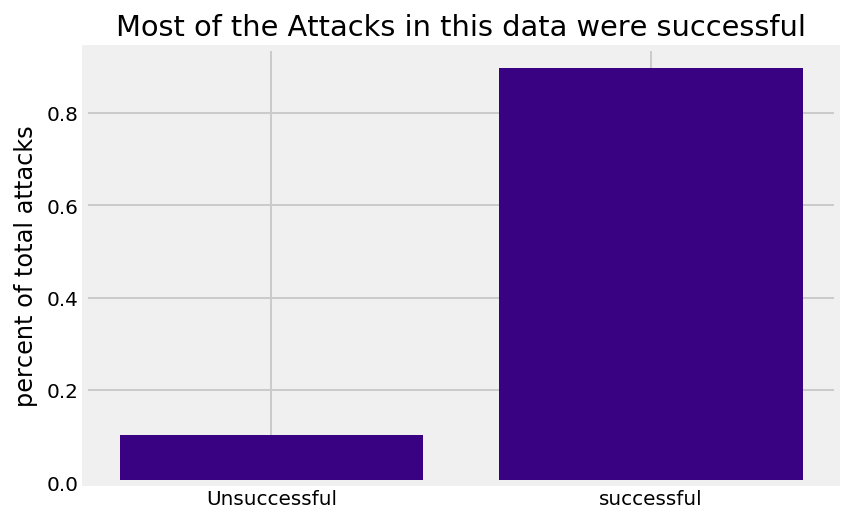

In [115]:
# terrorism succes
terrorism_success_rate = df['success'].value_counts(True).sort_values()
plt.bar(range(2), terrorism_success_rate, color='xkcd:indigo')
plt.xticks(range(2), ['Unsuccessful', 'successful'])
plt.ylabel('percent of total attacks')
plt.title('Most of the Attacks in this data were successful');

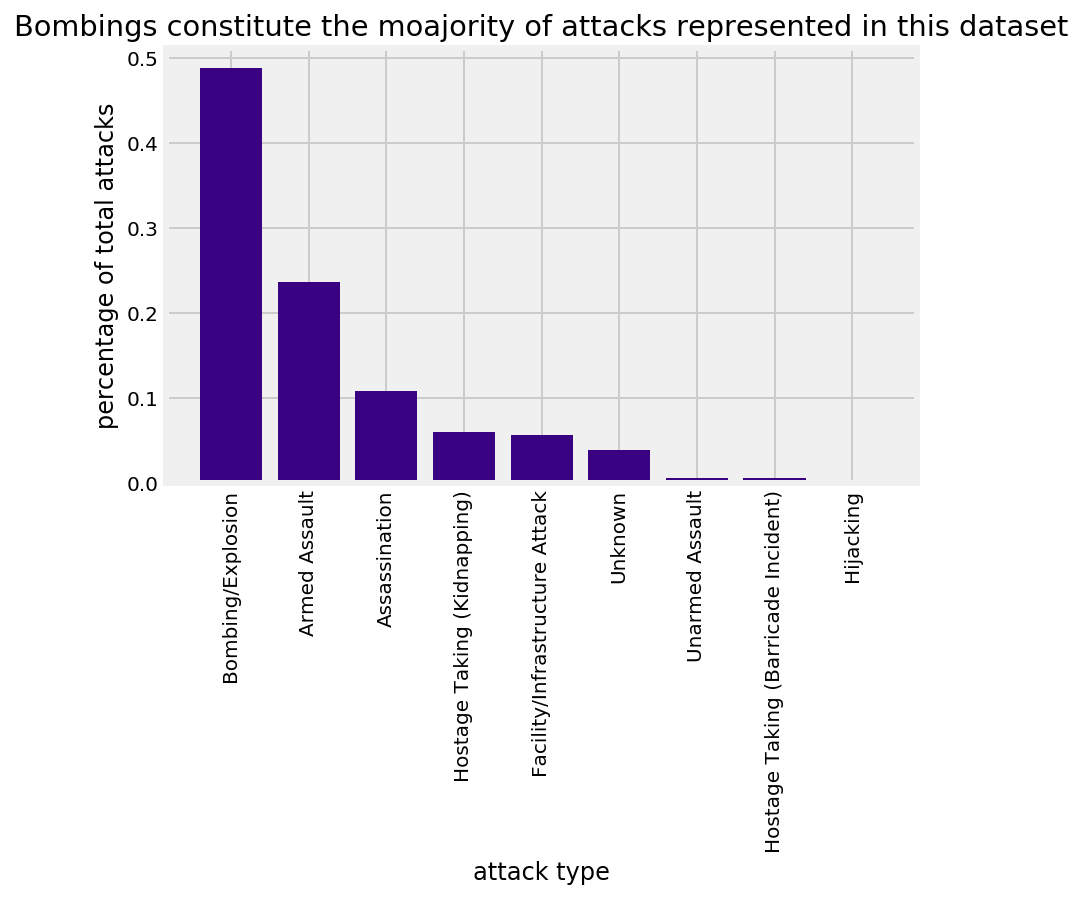

In [114]:
# attack types
attack_types = df['attacktype1_txt'].value_counts(True)
plt.bar(range(len(attack_types)), attack_types, color='xkcd:indigo')
plt.xticks(range(len(attack_types)), attack_types.index, rotation=90)
plt.xlabel('attack type')
plt.ylabel('percentage of total attacks')
plt.title('Bombings constitute the moajority of attacks represented in this dataset');

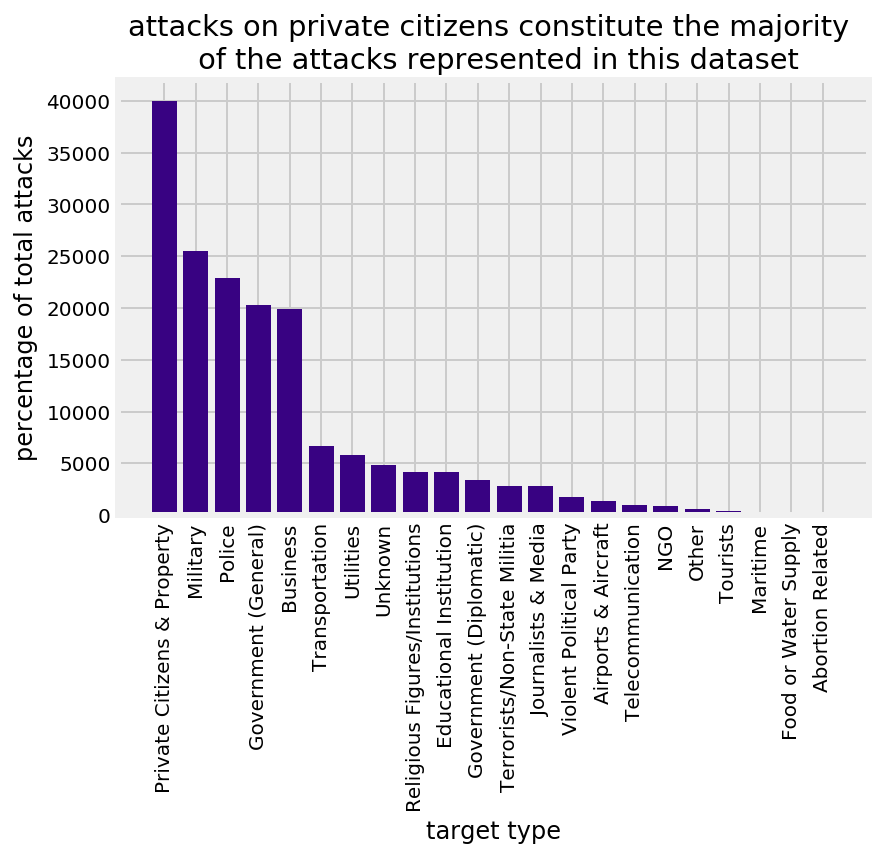

In [117]:
# target types
target_types = df['targtype1_txt'].value_counts()
plt.bar(range(len(target_types)), target_types, color='xkcd:indigo')
plt.xticks(range(len(target_types)), target_types.index, rotation=90)
plt.xlabel('target type')
plt.ylabel('percentage of total attacks')
plt.title('attacks on private citizens constitute the majority \n of the attacks represented in this dataset');

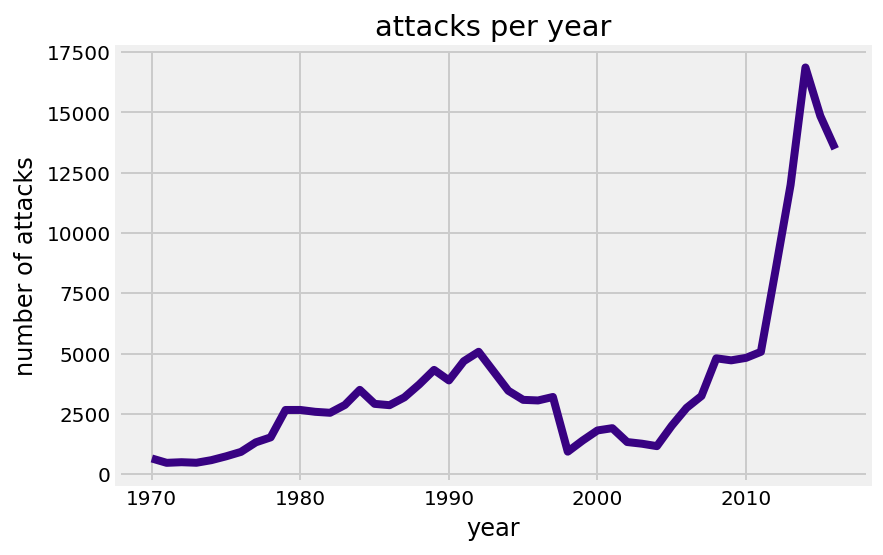

In [124]:
# attacks by year
attacks_per_year = df.groupby('iyear')['attacktype1'].count()
plt.plot(attacks_per_year, color='xkcd:indigo')
plt.title('attacks per year')
plt.xlabel('year')
plt.ylabel('number of attacks');

In [ ]:
plt.plot()

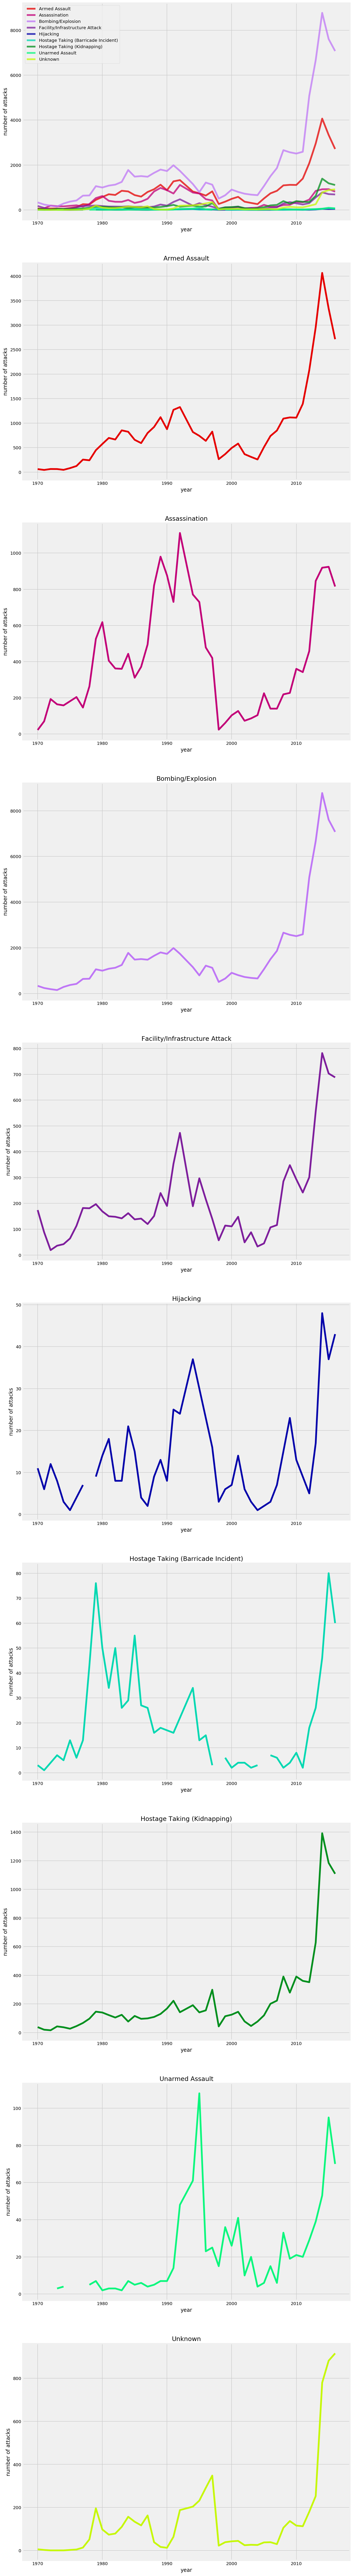

In [139]:
colors = ['xkcd:red', 
          'xkcd:magenta',  
          'xkcd:light purple',
          'xkcd:purple', 
          'xkcd:royal blue', 
          'xkcd:aquamarine', 
          'xkcd:emerald green', 
          'xkcd:minty green', 
          'xkcd:greeny yellow', 
          'xkcd:yellow orange', 
          'xkcd:orange',
          'black',
          'xkcd:dark pink', 
          'xkcd:burgundy', 
          'xkcd:bright teal', 
          'xkcd:shocking pink', 
          'xckd:robin\'s egg', 
          'xkcd:dusty green', 
          'xkcd:pea soup green']

attacks_per_year_by_attack = df.groupby('iyear')['attacktype1_txt'].value_counts().unstack()
fig, ax = plt.subplots(nrows=len(attacks_per_year_by_attack.columns) + 1,
                       ncols=1,
                       figsize=(12, 12*len(attacks_per_year_by_attack.columns)))
for count, attacktype in enumerate(attacks_per_year_by_attack):
    ax[0].plot(attacks_per_year_by_attack[attacktype], color=colors[count], alpha=0.75)
    ax[count + 1].plot(attacks_per_year_by_attack[attacktype], color=colors[count])
    ax[count + 1].set_title(attacktype)
    ax[count + 1].set_ylabel('number of attacks')
    ax[count + 1].set_xlabel('year')
    
ax[0].legend()
ax[0].set_ylabel('number of attacks')
ax[0].set_xlabel('year');

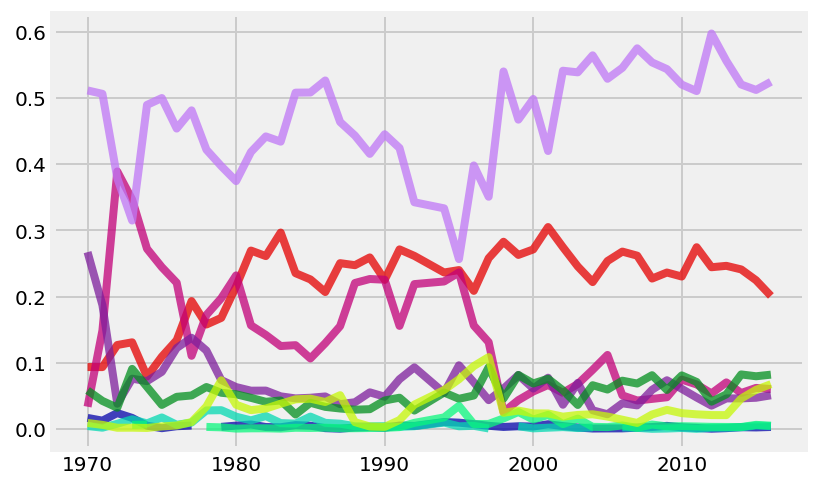

In [182]:
normalized_attacks_per_year_by_attack = df.groupby('iyear')['attacktype1_txt'].value_counts(True).unstack()
for count, attacktype in enumerate(normalized_attacks_per_year_by_attack):
    plt.plot(normalized_attacks_per_year_by_attack[attacktype], color=colors[count], alpha=0.75)

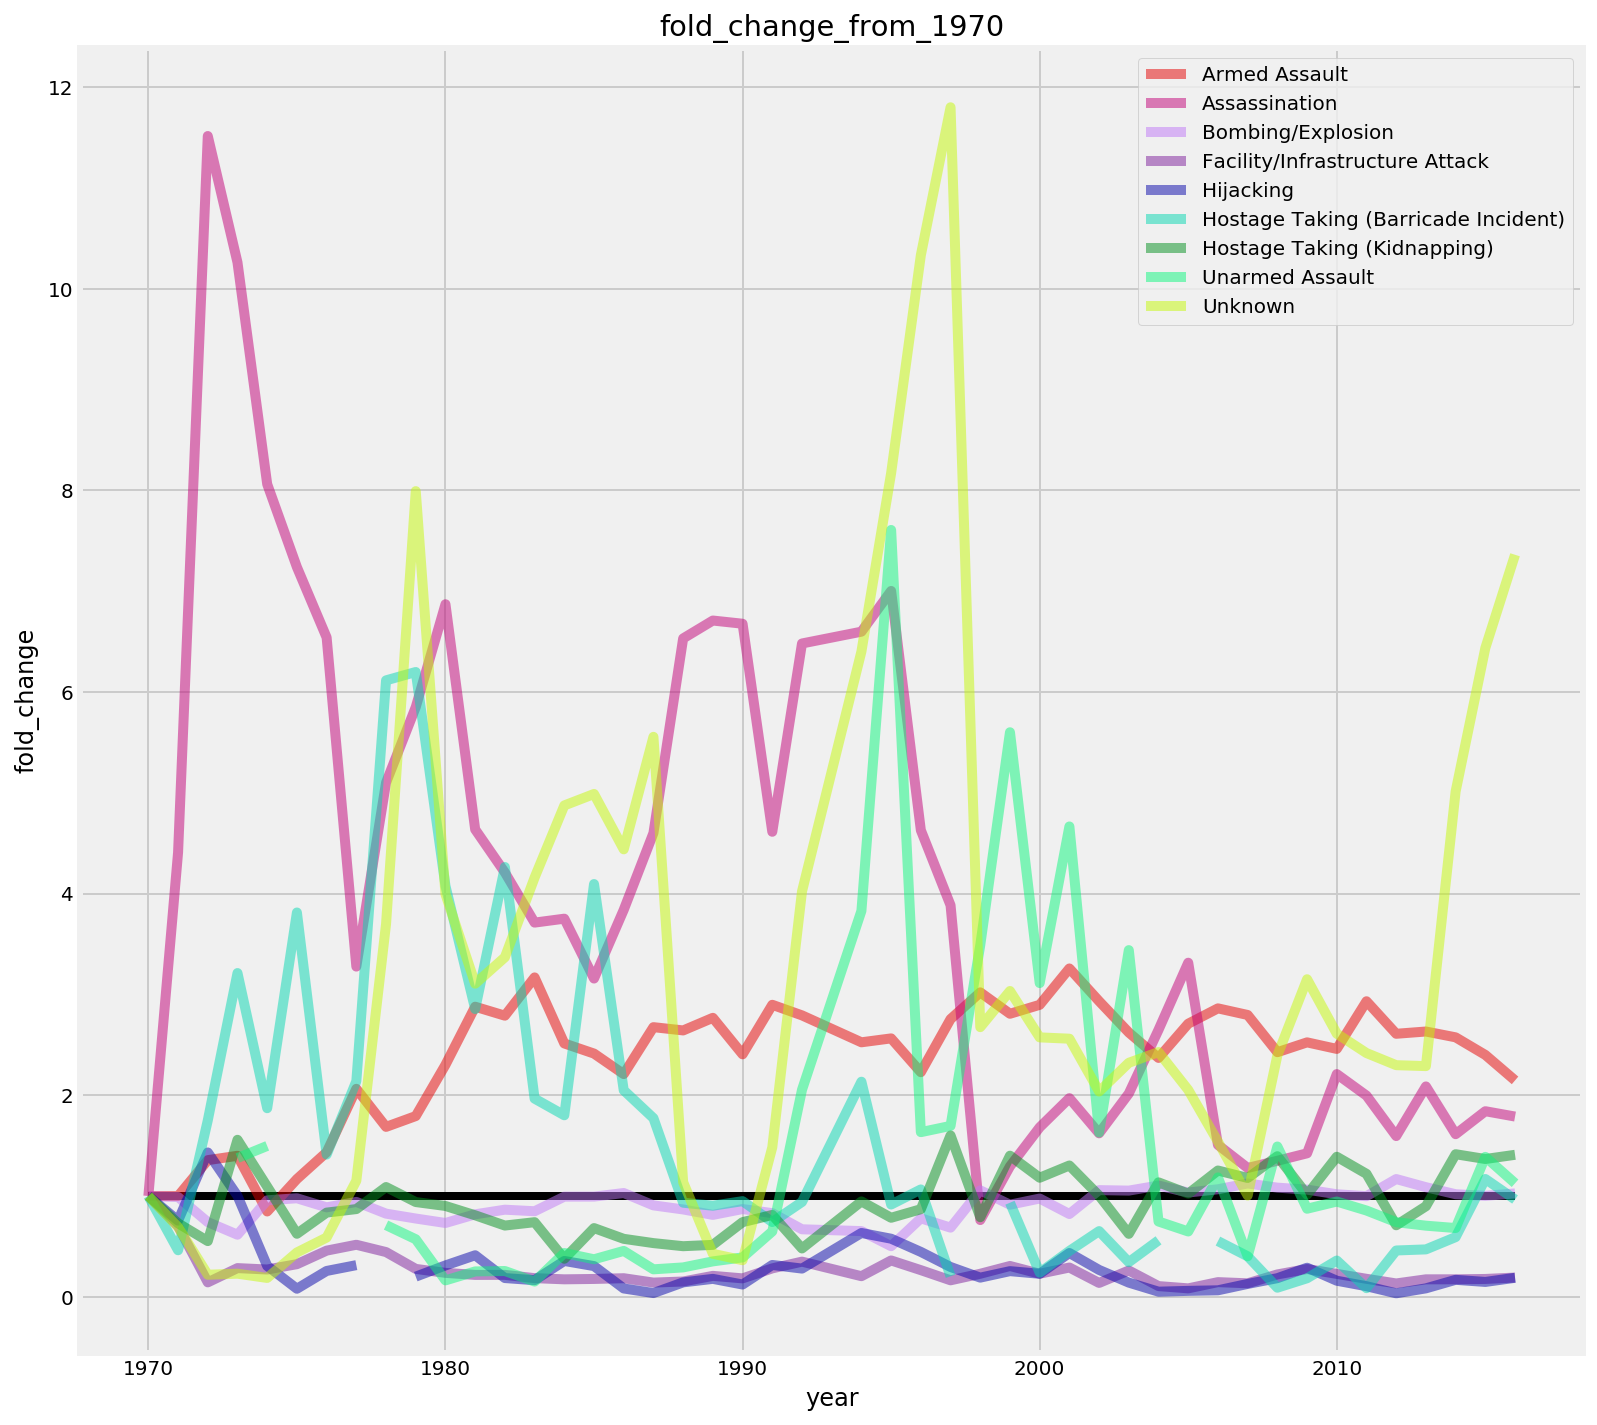

In [200]:
plt.figure(figsize=(12, 12))

for count, attacktype in enumerate(normalized_attacks_per_year_by_attack):
    value_1970 = normalized_attacks_per_year_by_attack[attacktype].values[0]
    fold_change_from_1970 = normalized_attacks_per_year_by_attack[attacktype] / value_1970
    plt.plot(fold_change_from_1970, color=colors[count], alpha=0.5, lw=5)
    
plt.legend()
plt.hlines(y=1, xmin=1970, xmax=2016)
plt.title('fold_change_from_1970')
plt.ylabel('fold_change')
plt.xlabel('year');

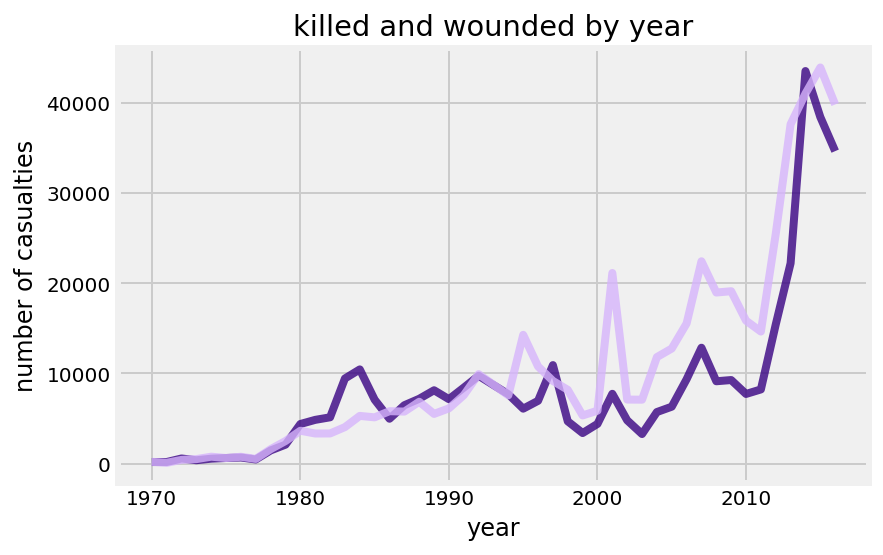

In [201]:
killed_and_wounded_per_year = df.groupby('iyear')[['nkill', 'nwound']].sum()
plt.plot(killed_and_wounded_per_year['nkill'], color='xkcd:indigo', alpha=0.8)
plt.plot(killed_and_wounded_per_year['nwound'], color='xkcd:light violet', alpha=0.8)
plt.title('killed and wounded by year')
plt.xlabel('year')
plt.ylabel('number of casualties');

In [167]:
k_w_df = df.groupby('iyear')[['nkill', 'nwound']].agg(['sum', 'count'])

k_w_df.columns = ['nkill_sum', 'nkill_count', 'nwound_sum', 'nwound_count']

k_w_df['total_casualities'] = k_w_df['nkill_sum'] + k_w_df['nwound_sum']

k_w_df['casualties_per_attack'] = k_w_df['total_casualities'] / k_w_df['nwound_count']

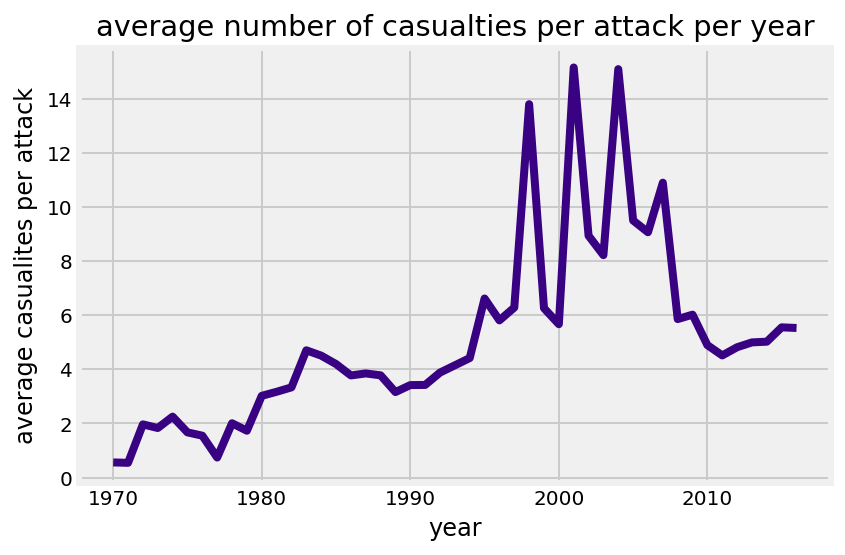

In [178]:
plt.plot(k_w_df['casualties_per_attack'], color='xkcd:indigo')
plt.title('average number of casualties per attack per year')
plt.xlabel('year')
plt.ylabel('average casualites per attack');

In [244]:
def terror_by_year_plotter(df, cols=['international', 'total_dom'], title='title', title2='title'):
    
    colors = ['xkcd:light violet', 'xkcd:indigo']
    
    fig, ax = plt.subplots(2, 1, figsize=(18, 24))
    
    total_by_year = np.sum(df[cols], axis=1).values
    
    years = df.index
    
    bottom_start = 0
    
    # line plot over time
    for count, col in enumerate(cols):
        c = colors[count]
        scaled_col = np.divide(df[col].values, total_by_year)
        
        ax[0].plot(df[col], color=c)
        
        if count == 0:
            ax[1].bar(years, scaled_col, color=c)
            bottom_start = scaled_col
            
        else:
            ax[1].bar(years, scaled_col, bottom=bottom_start, color=c)
            bottom_start = bottom_start + scaled_col
        
    ax[0].legend(fontsize=20)
    ax[0].set_title(title, fontsize=25, weight='bold')
    ax[0].set_ylabel('Attacks in the US')
    
    ax[1].hlines(y=0.5, xmin=1970, xmax=2016)
    ax[1].set_title(title2, fontsize=25, weight='bold')
    ax[1].set_ylabel('Percentage of attacks per year')
    ax[1].set_xlabel('Year')

In [210]:
us_attacks = df.loc[df['country'] == 217]

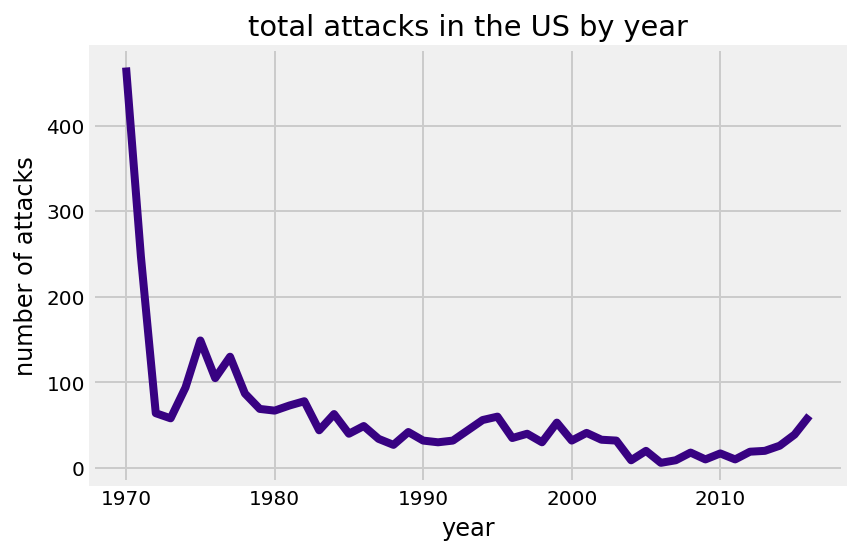

In [212]:
plt.plot(us_attacks.groupby('iyear')['attacktype1'].count(), color='xkcd:indigo')
plt.title('total attacks in the US by year')
plt.xlabel('year')
plt.ylabel('number of attacks');

Text(0.5,0,'origin of attack ideologies')

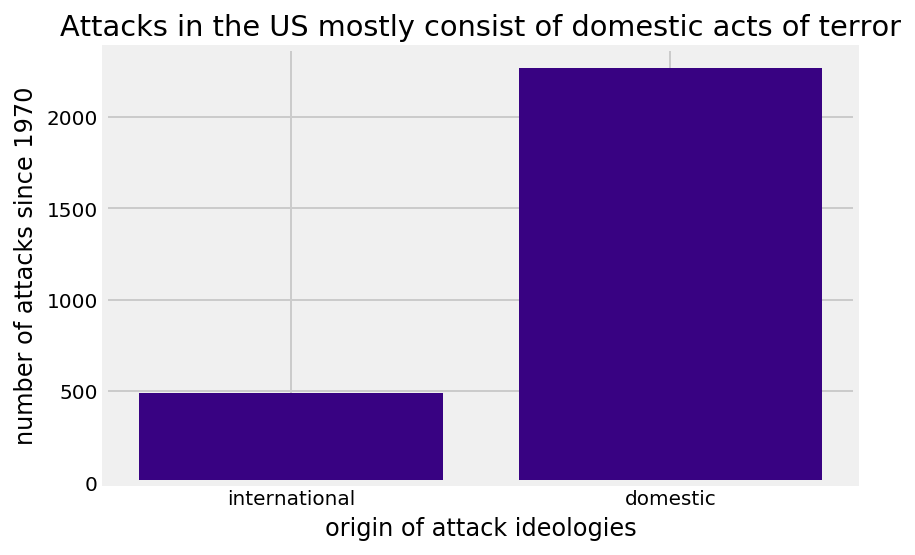

In [222]:
international_us_attacks = us_attacks.loc[us_attacks['INT_IDEO'] == 1].shape[0]
domestic_us_attacks      = us_attacks.loc[~(us_attacks['INT_IDEO'] == 1)].shape[0]

plt.bar(range(2), [international_us_attacks, domestic_us_attacks], color='xkcd:indigo')
plt.title('Attacks in the US mostly consist of domestic acts of terror')
plt.ylabel('number of attacks since 1970')
plt.xticks(range(2), ['international', 'domestic'])
plt.xlabel('origin of attack ideologies')

In [213]:
us_attacks_year = pd.DataFrame(us_attacks.groupby('iyear')['INT_IDEO'].value_counts()).unstack()

us_attacks_year.fillna(0, inplace=True)

us_attacks_year.columns = ['unknown', 'domestic', 'international']

us_attacks_year['total_dom'] = us_attacks_year['unknown'] + us_attacks_year['domestic']

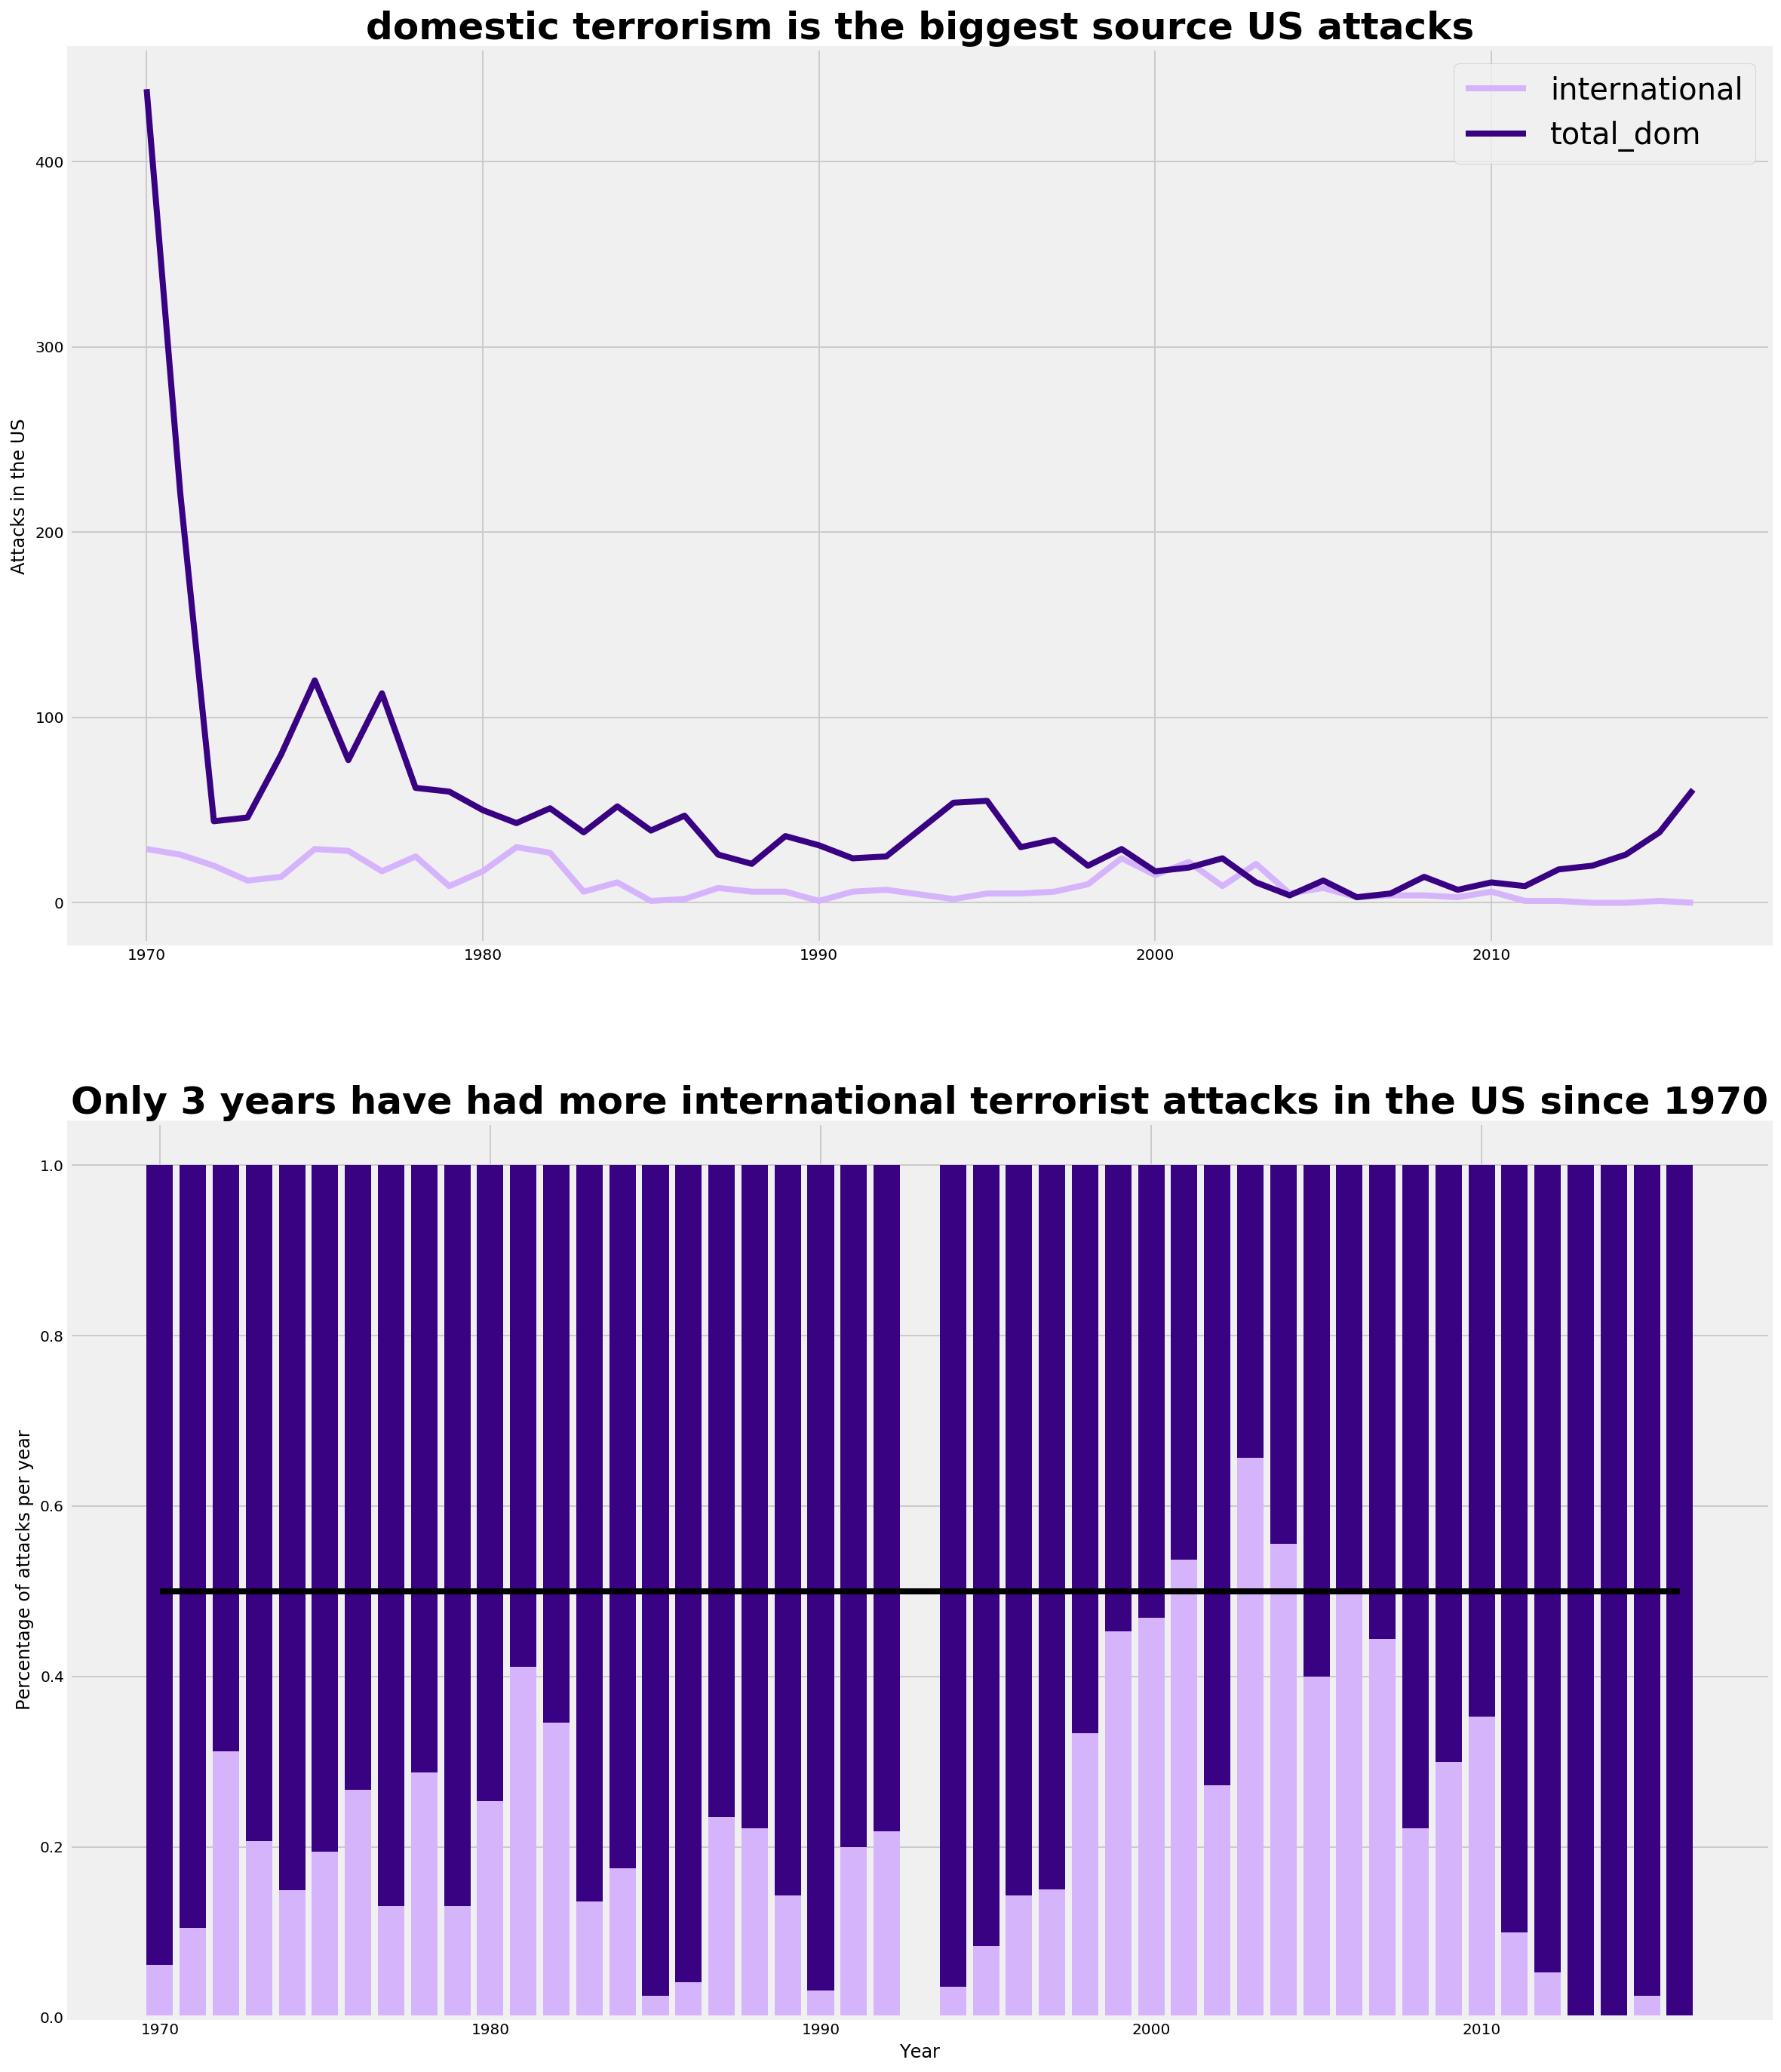

In [245]:
terror_by_year_plotter(us_attacks_year, 
                       title='domestic terrorism is the biggest source US attacks', 
                       title2='Only 3 years have had more international terrorist attacks in the US since 1970')

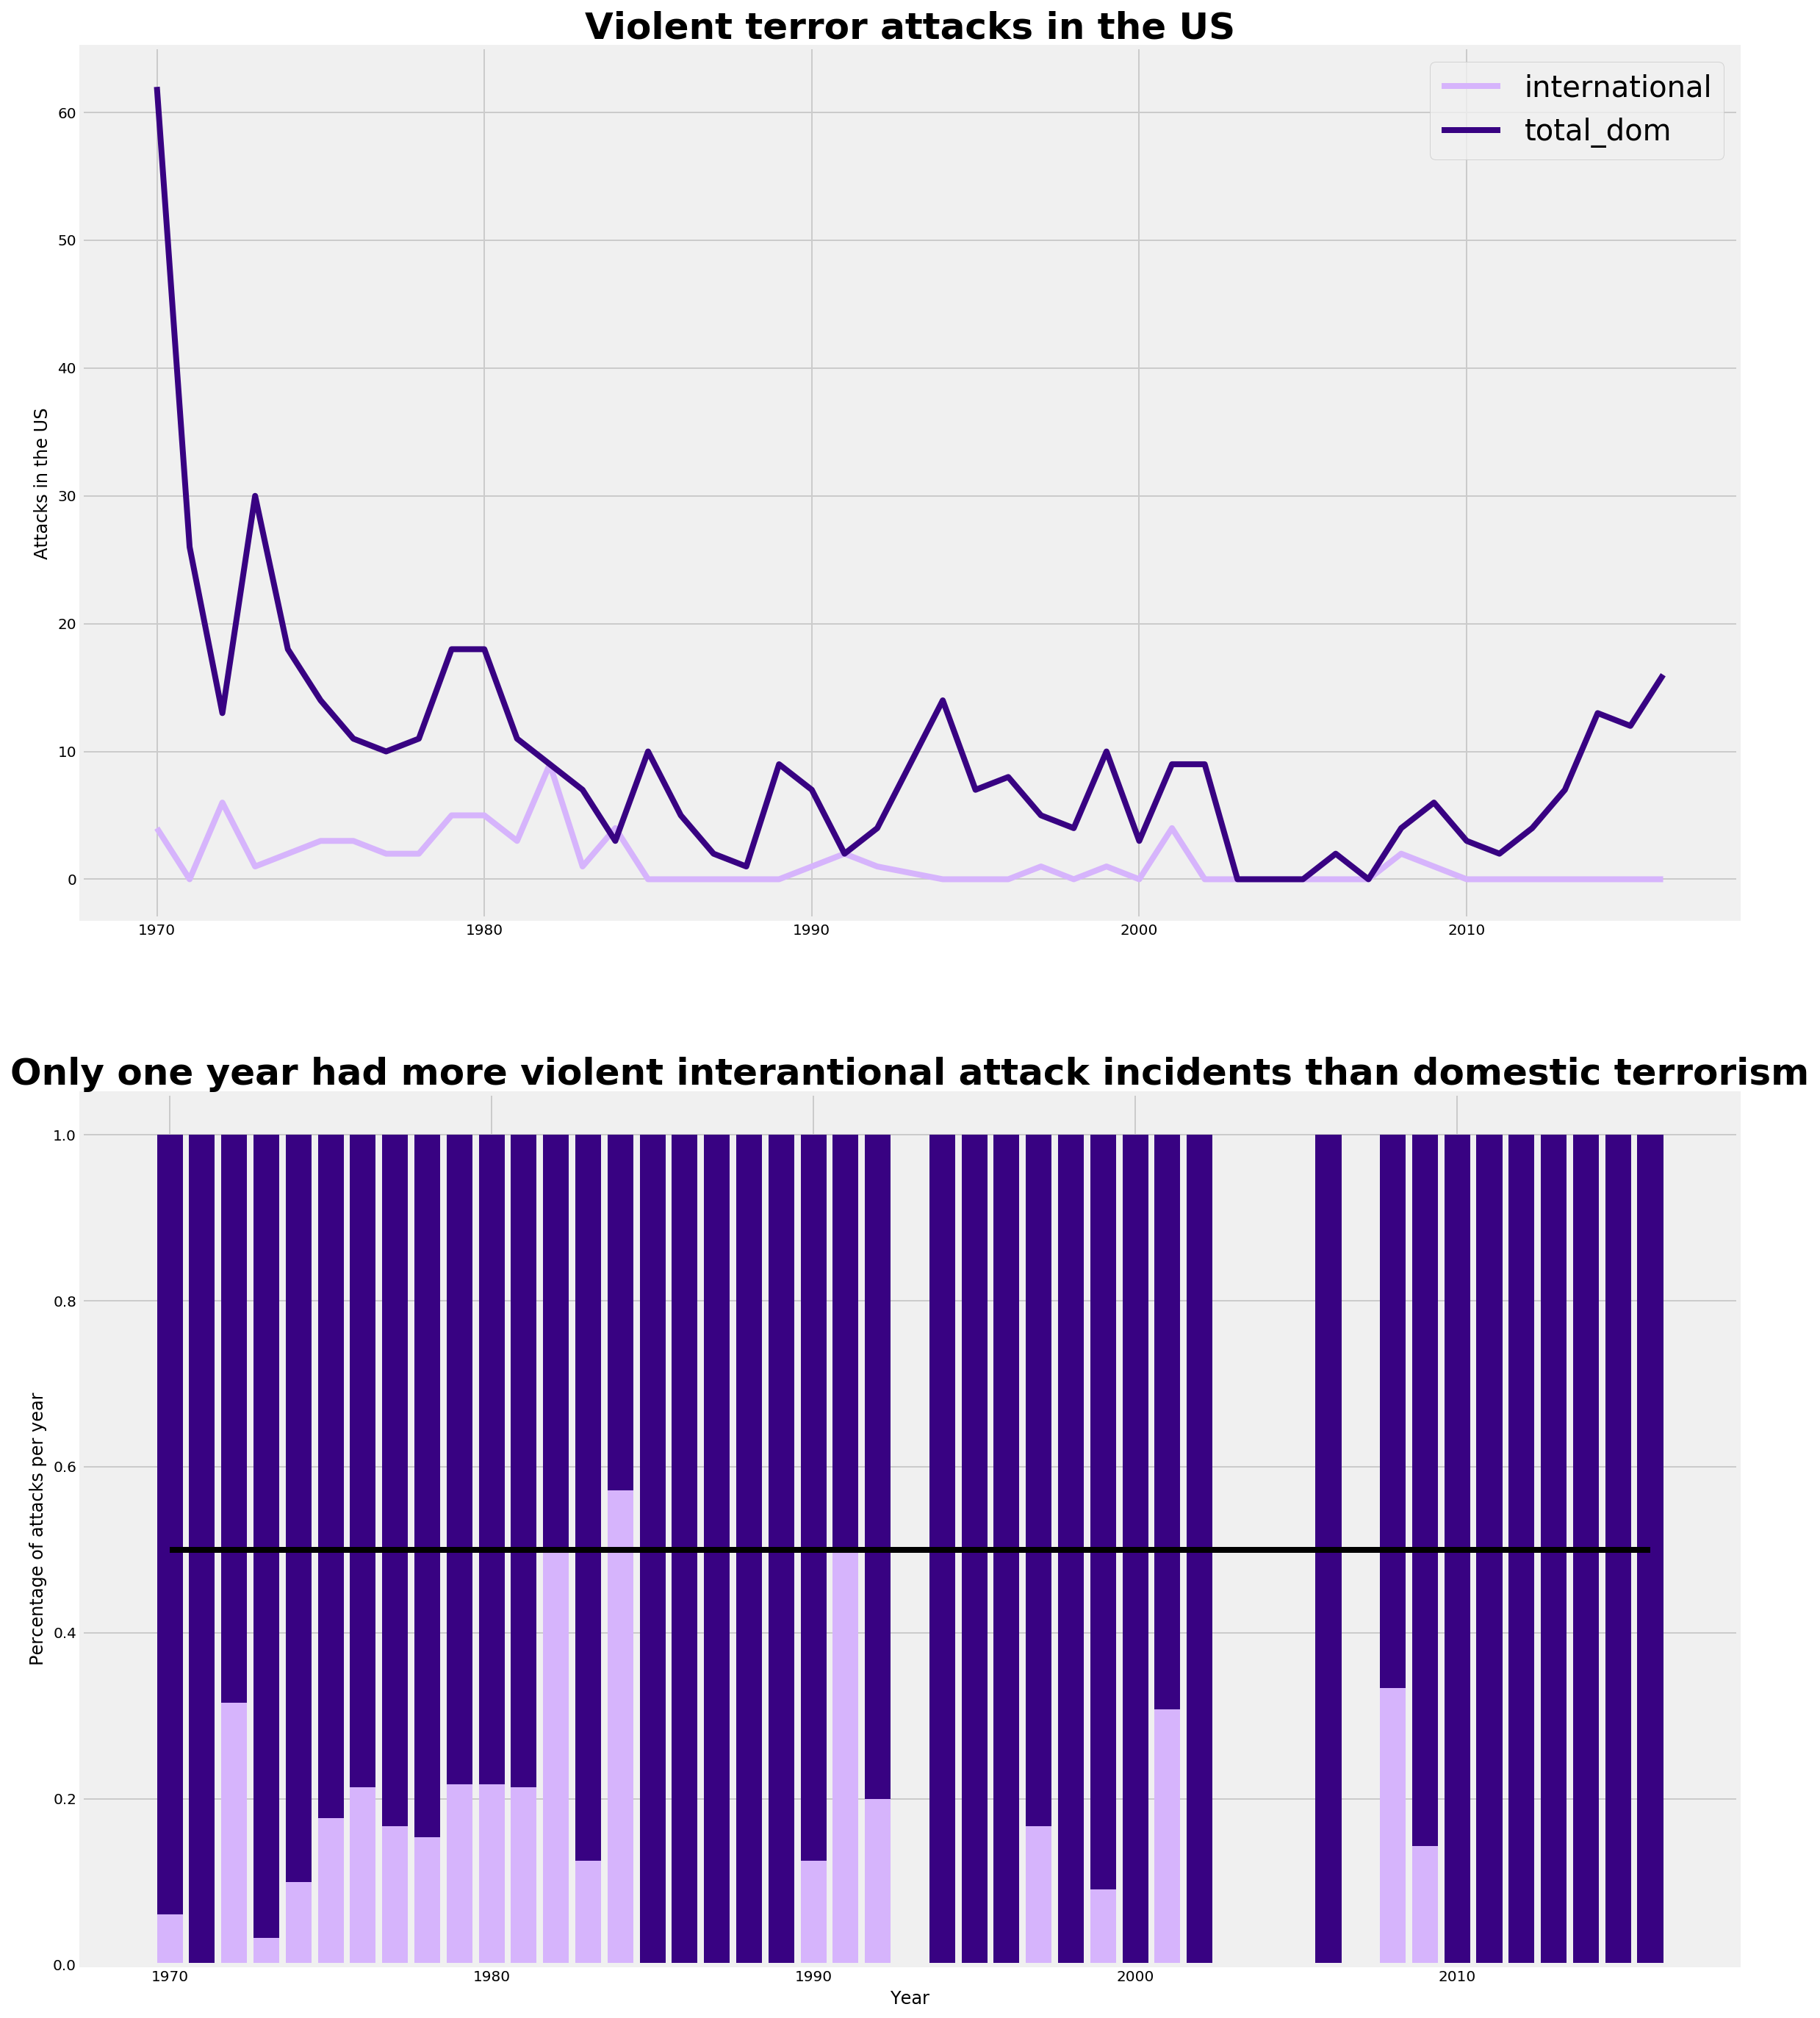

In [247]:
leathal_us_attacks = us_attacks.loc[(us_attacks['nwound'] > 0) | (us_attacks['nkill'] > 0)]

lethal_attacks_us = leathal_us_attacks.groupby('iyear')['INT_IDEO'].value_counts().unstack().fillna(0)

lethal_attacks_us.columns = ['unknown', 'domestic', 'international']

lethal_attacks_us['total_dom'] = lethal_attacks_us['unknown'] + lethal_attacks_us['domestic']

lethal_attacks_us = lethal_attacks_us.drop(['unknown', 'domestic'], axis=1)

for year in range(1994, 2017):
    if year in lethal_attacks_us.index:
        pass
    else:
        lethal_attacks_us = lethal_attacks_us.append(
            pd.DataFrame(
                {
                    'international': 0,
                    'total_dom'    : 0
                },
                index = [year]
            )
        )
        
lethal_attacks_us =lethal_attacks_us.sort_index().sort_index()

terror_by_year_plotter(lethal_attacks_us,
                       title='Violent terror attacks in the US',
                       title2='Only one year had more violent interantional attack incidents than domestic terrorism')

### Tableau Visualizations

`In the link below there are four more visualizations: 1) Terrorist Attacks by country per year, 2) Armed Assults per year, 3) Assasinations per year and 4) Bombings per year. The first visualization shows the total number of attacks per year per country with the color of the country indicating how many total attacks occured. Visualizations 2 through 4 shoe the geolocation of each attack for each year. The size of the dots indicates the number of people killed by a specific attack and the color indeicates the number wounded.`

`This is the link to my tableau profile:` https://public.tableau.com/profile/adam.bailin#!/

#### Tableau 1

In [206]:
%%HTML
<div class='tableauPlaceholder' id='viz1522791057219' style='position: relative'><noscript><a href='#'><img alt='Total terror Attacks per country - 2016 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-totalattackspercountryperyear&#47;TotalterrorAttackspercountry&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Terrorismdata-totalattackspercountryperyear&#47;TotalterrorAttackspercountry' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-totalattackspercountryperyear&#47;TotalterrorAttackspercountry&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1522791057219');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

#### Tableau 2

In [205]:
%%HTML 
<div class='tableauPlaceholder' id='viz1522790866725' style='position: relative'><noscript><a href='#'><img alt='Armed Assault - 2016 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-Armedassaultperyear&#47;ArmedAssault&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Terrorismdata-Armedassaultperyear&#47;ArmedAssault' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-Armedassaultperyear&#47;ArmedAssault&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='useGuest' value='true' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1522790866725');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

#### Tableau 3

In [207]:
%%HTML 
<div class='tableauPlaceholder' id='viz1522791107702' style='position: relative'><noscript><a href='#'><img alt='Assasinations - 2016 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-Assasinationsperyear&#47;Assasinations&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Terrorismdata-Assasinationsperyear&#47;Assasinations' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-Assasinationsperyear&#47;Assasinations&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1522791107702');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

#### Tableau 4

In [208]:
%%HTML 
<div class='tableauPlaceholder' id='viz1522791139292' style='position: relative'><noscript><a href='#'><img alt='Bombing - 1970 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-Bombingsperyear&#47;Bombing&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Terrorismdata-Bombingsperyear&#47;Bombing' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;Terrorismdata-Bombingsperyear&#47;Bombing&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1522791139292');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

# Part Two

`In the US specific data there appears to be a noticable difference between the number of incidents between the era of the Bush administration and the Obama Administration. I will examine both attacks that resulted in casualities and attacks in general. The increase in attacks could reflect the increase in white supremacist activity.`

### Attacks that resulted in casualities

In [251]:
prior_mean = lethal_attacks_us['total_dom'].mean()
prior_std  = lethal_attacks_us['total_dom'].std()

attacks_during_obama = lethal_attacks_us.loc[lethal_attacks_us.index >= 2009]['total_dom']
attacks_during_bush  = lethal_attacks_us.loc[(lethal_attacks_us.index >= 2001) & (lethal_attacks_us.index <= 2008)]['total_dom']

In [252]:
with pm.Model() as model:
    obama_presidency_dom_mean = pm.Normal('o_mean', prior_mean, sd=prior_std)
    bush_presidency_dom_mean  = pm.Normal('b_mean', prior_mean, sd=prior_std)
    
    obama_presidency_dom_std = pm.Gamma('o_std', mu=prior_std, sd=50)
    bush_presidency_dom_std  = pm.Gamma('b_std', mu=prior_std, sd=50)
    
    o_era_attacks = pm.Normal('o_era_attacks',
                              mu=obama_presidency_dom_mean,
                              sd=obama_presidency_dom_std,
                              observed=attacks_during_obama)
    b_era_attacks = pm.Normal('b_era_attacks',
                              mu=bush_presidency_dom_mean, 
                              sd=bush_presidency_dom_std,
                              observed=attacks_during_bush)
    
    mean_delta = pm.Deterministic('mean_delta', obama_presidency_dom_mean - bush_presidency_dom_mean)
    std_delta = pm.Deterministic('std_delta', obama_presidency_dom_std - bush_presidency_dom_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((obama_presidency_dom_std**2 + bush_presidency_dom_std**2)/2.))

with model:
    step = pm.NUTS()

/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


In [253]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=4)

/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
logp = -62.452, ||grad|| = 1.342: 100%|██████████| 21/21 [00:00<00:00, 523.56it/s]  
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_std_log__, o_std_log__, b_mean, o_mean]
INFO:pymc3:NUTS: [b_std_log__, o_std_log__, b_mean, o_mean]
100%|██████████| 50500/50500 [03:35<00:00, 234.29it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


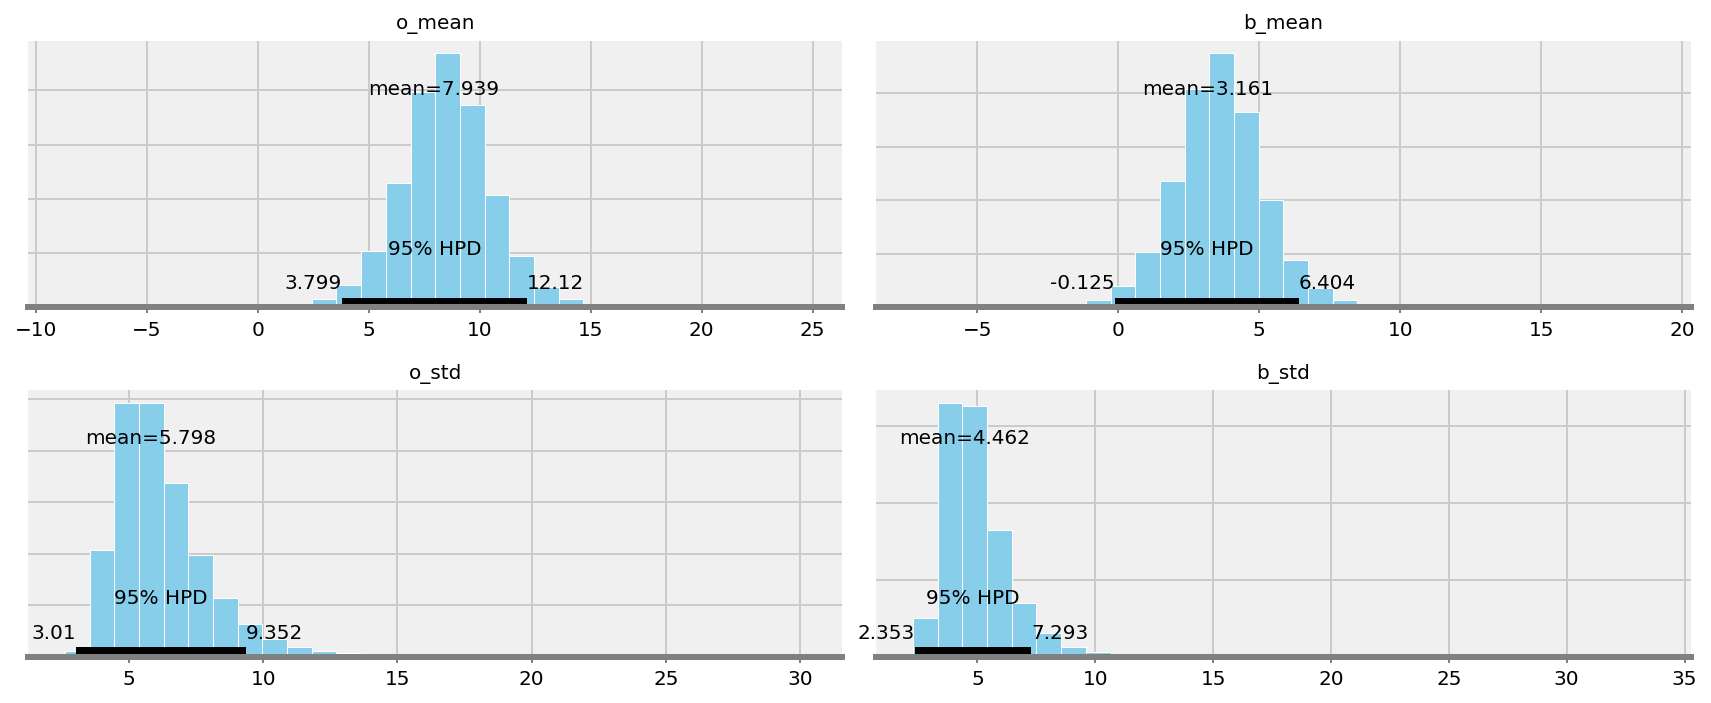

In [259]:
pm.plot_posterior(trace[:50000],
                  varnames=['o_mean', 'b_mean', 'o_std', 'b_std'],
                  color='#87ceeb');

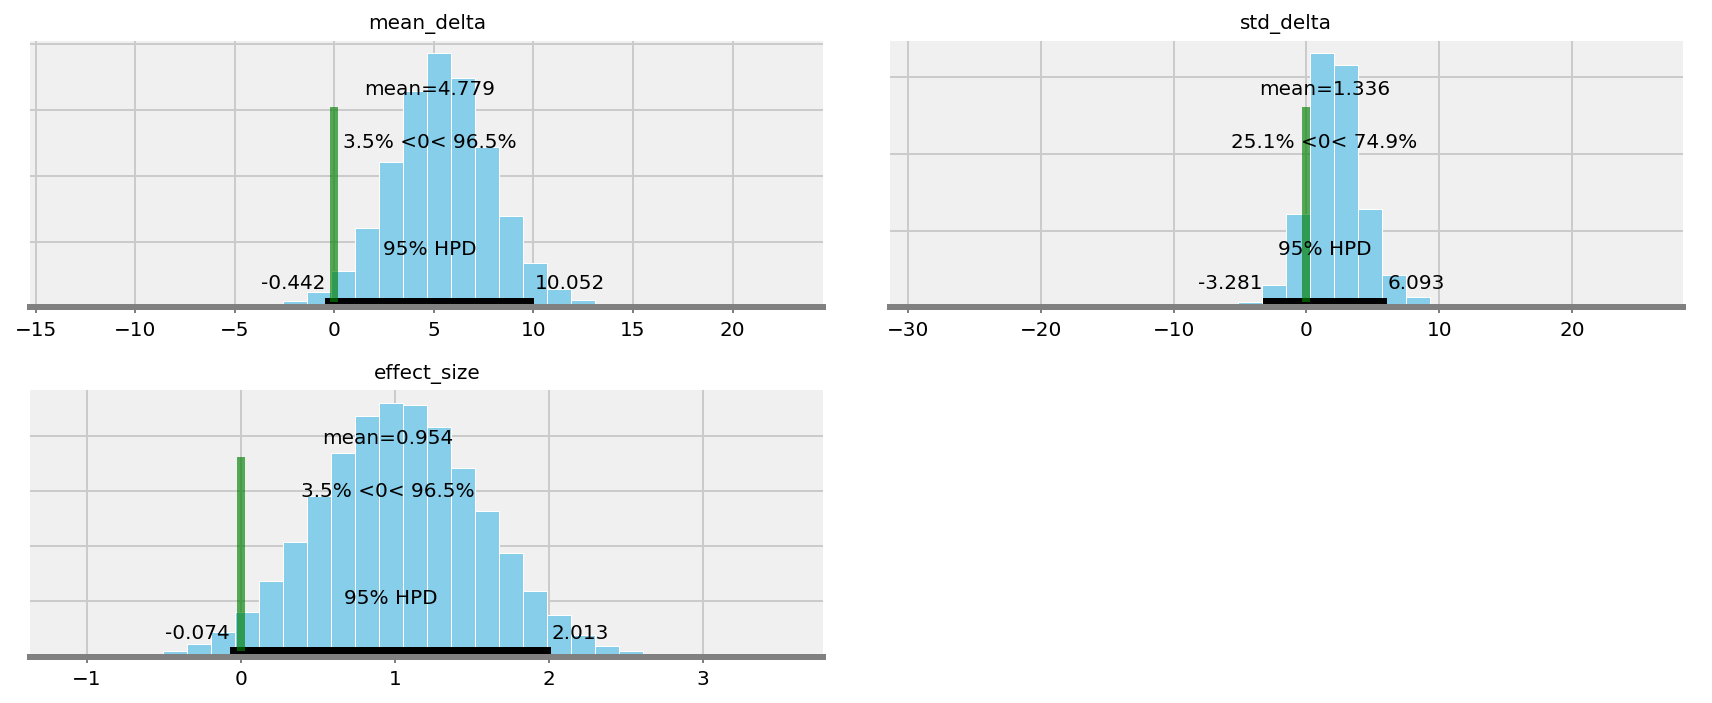

In [260]:
pm.plot_posterior(trace[:50000],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0);

### All us attacks

In [261]:
prior_mean = us_attacks_year['total_dom'].mean()
prior_std  = us_attacks_year['total_dom'].std()

attacks_during_obama = us_attacks_year.loc[us_attacks_year.index >= 2009]['total_dom']
attacks_during_bush  = us_attacks_year.loc[(us_attacks_year.index >= 2001) & (us_attacks_year.index <= 2008)]['total_dom']

In [262]:
with pm.Model() as model:
    obama_presidency_dom_mean = pm.Normal('o_mean', prior_mean, sd=prior_std)
    bush_presidency_dom_mean  = pm.Normal('b_mean', prior_mean, sd=prior_std)
    
    obama_presidency_dom_std = pm.Gamma('o_std', mu=prior_std, sd=50)
    bush_presidency_dom_std  = pm.Gamma('b_std', mu=prior_std, sd=50)
    
    o_era_attacks = pm.Normal('o_era_attacks',
                              mu=obama_presidency_dom_mean,
                              sd=obama_presidency_dom_std,
                              observed=attacks_during_obama)
    b_era_attacks = pm.Normal('b_era_attacks',
                              mu=bush_presidency_dom_mean, 
                              sd=bush_presidency_dom_std,
                              observed=attacks_during_bush)
    
    mean_delta = pm.Deterministic('mean_delta', obama_presidency_dom_mean - bush_presidency_dom_mean)
    std_delta = pm.Deterministic('std_delta', obama_presidency_dom_std - bush_presidency_dom_std)
    effect_size = pm.Deterministic('effect_size', mean_delta / np.sqrt((obama_presidency_dom_std**2 + bush_presidency_dom_std**2)/2.))

with model:
    step = pm.NUTS()

/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


In [263]:
with model:
    step = pm.NUTS()
    start = pm.find_MAP()
    trace = pm.sample(50000, start=start, step=step, njobs=4)

/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
logp = -81.454, ||grad|| = 0.42618: 100%|██████████| 36/36 [00:00<00:00, 1094.82it/s]        
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_std_log__, o_std_log__, b_mean, o_mean]
INFO:pymc3:NUTS: [b_std_log__, o_std_log__, b_mean, o_mean]
100%|██████████| 50500/50500 [04:09<00:00, 202.42it/s]


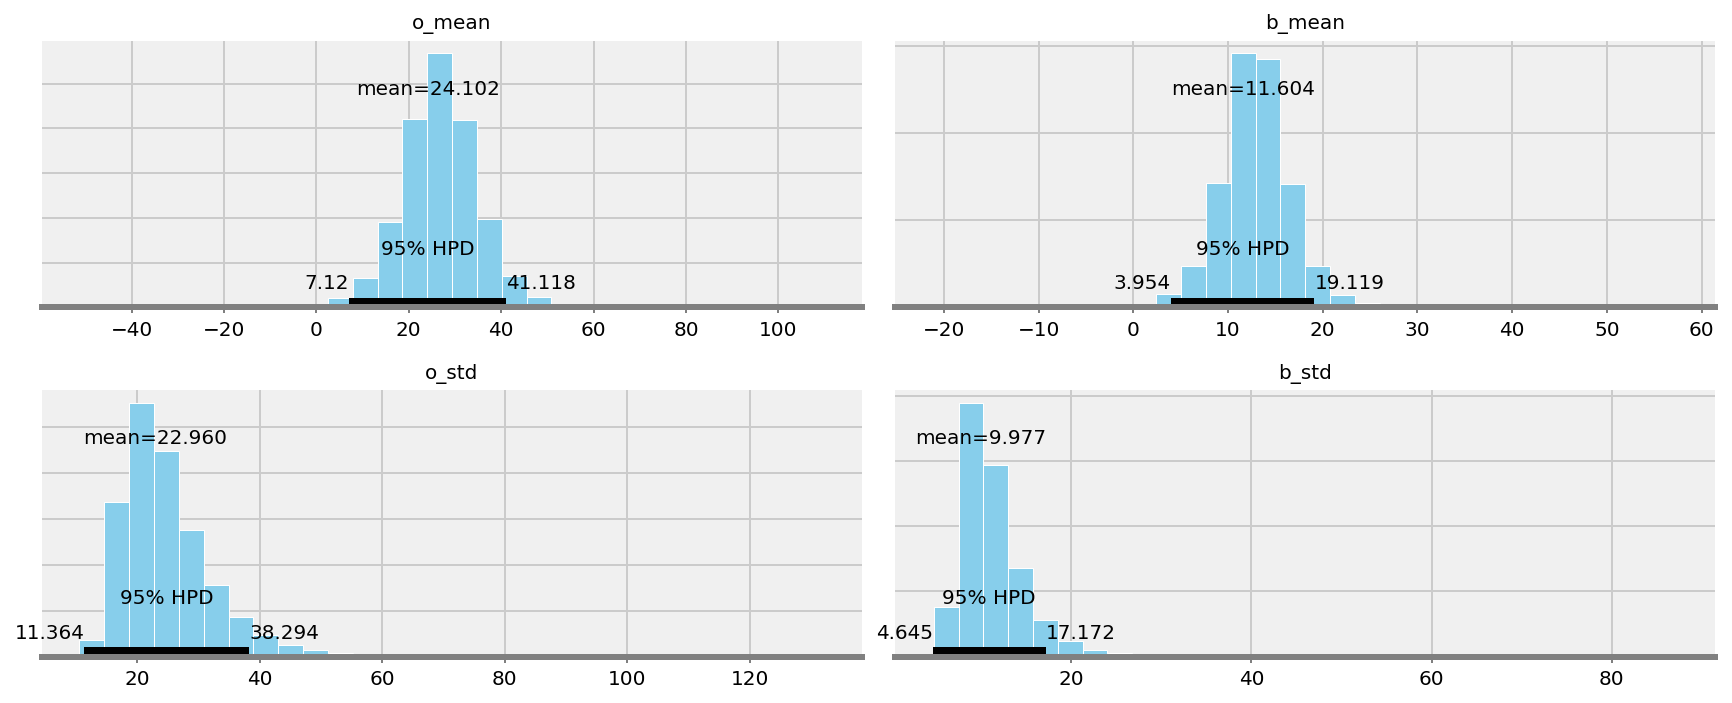

In [264]:
pm.plot_posterior(trace[:50000],
                  varnames=['o_mean', 'b_mean', 'o_std', 'b_std'],
                  color='#87ceeb');

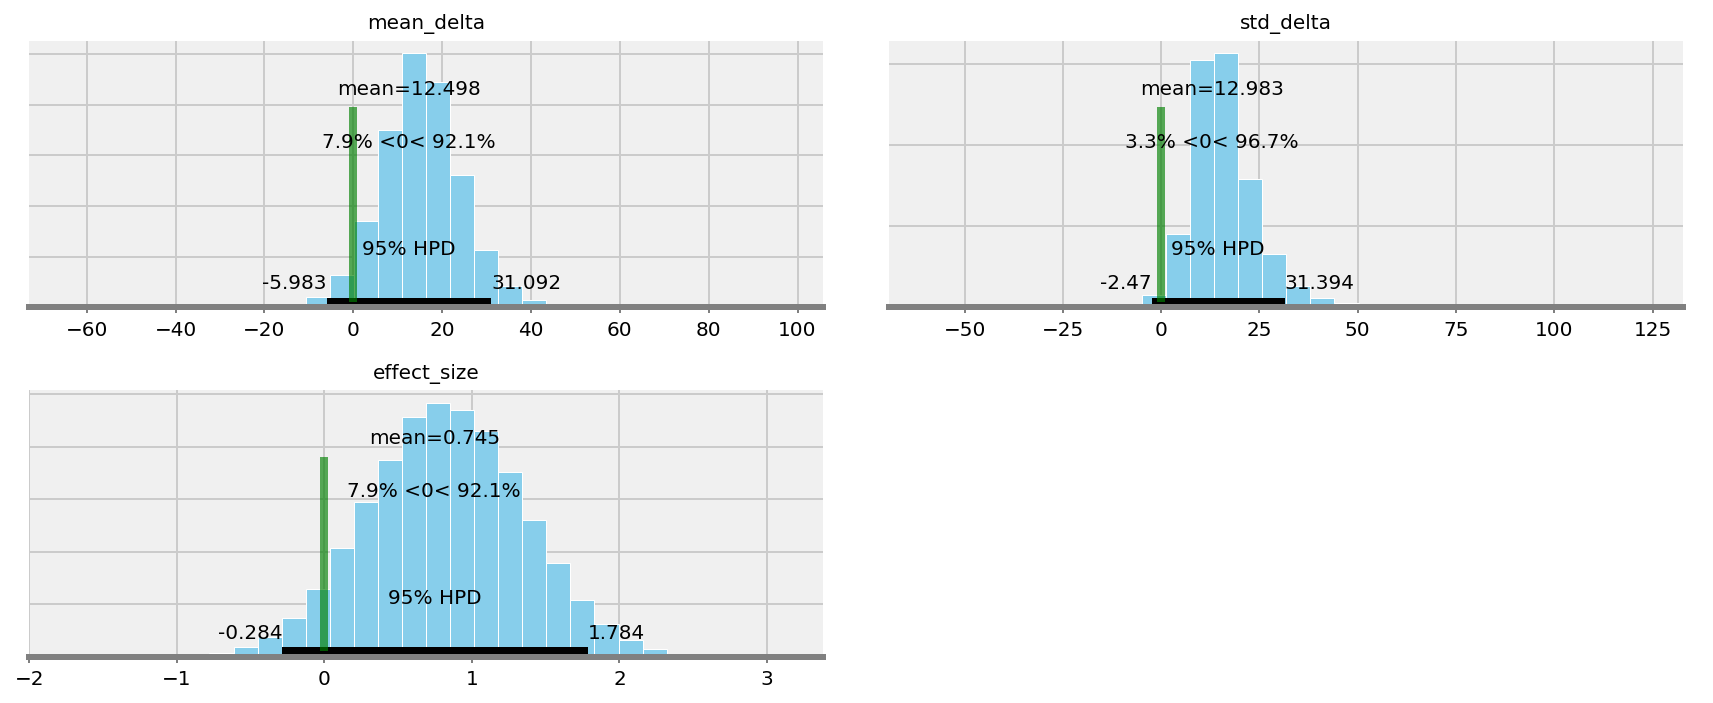

In [265]:
pm.plot_posterior(trace[:50000],
                  varnames=['mean_delta','std_delta','effect_size'],
                  color='#87ceeb', ref_val=0);

`Using bayes analysis, with a 95% credible interval, the two presidential eras are not difinitively different. I used a prior based of of the average terror attacks and std_dev per year. The number of terror attacks in the US in the era of bush was not distinctly different from the obama era.`

# Part 3 - Infer number of bombings in 1993

`I split up the bombing data from 1988 to 1998 into bombings per country and then further split that by year and 
then used basyian regression methods to predict the number of bombings per country.`

In [268]:
bombings_per_country_per_year = pd.DataFrame(df.loc[(df['attacktype1'] == 3)
                                                    & (df['iyear'] >= 1988)
                                                    & (df['iyear'] <= 1998)].groupby('iyear')['country'].value_counts()).unstack()

bombings_per_country_per_year.fillna(0, inplace=True)

bombings_per_country_per_year.columns = bombings_per_country_per_year.columns.droplevel()

bombings_per_country_per_year = bombings_per_country_per_year.T

# average number of bombings per year from 1988 to 1998
(np.mean(bombings_per_country_per_year, axis=1)).sum()

1369.0999999999992

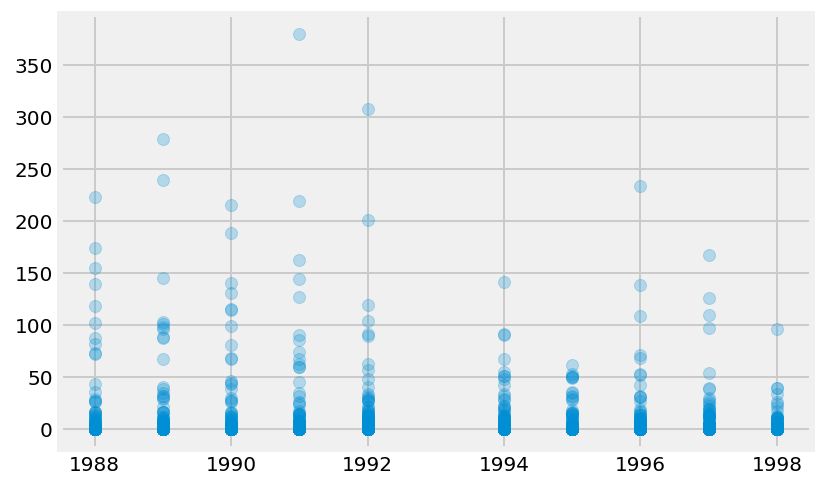

In [269]:
scatter_df = bombings_per_country_per_year.melt()
plt.scatter(scatter_df['iyear'], scatter_df['value'], alpha=0.25)

In [271]:
with pm.Model() as reg:
    
    # priors
    bombings_std = pm.HalfNormal('bombings_std',  sd=1.0) # std dev of residuals
    intercept    = pm.Normal('intercept',   mu=0, sd=10) # beta_0
    bombing_beta  = pm.Normal('bominb_beta', mu=0, sd=10) # beta_1
    
    # likelihood
    E_bombings = pm.Normal('E_bombings',
                           mu=intercept + (bombing_beta * scatter_df['iyear'].values),
                           sd=bombings_std,
                           observed=scatter_df['value'].values) # Expected APM

In [272]:
with reg:
    map_estimate = pm.find_MAP() # find the max a posteriori

map_estimate

logp = -7,567.1, ||grad|| = 0.015368: 100%|██████████| 32/32 [00:00<00:00, 1294.71it/s]       


{'bombings_std': array(24.38786467),
 'bombings_std_log__': array(3.19408566),
 'bominb_beta': array(0.00454719),
 'intercept': array(2.00539453e-05)}

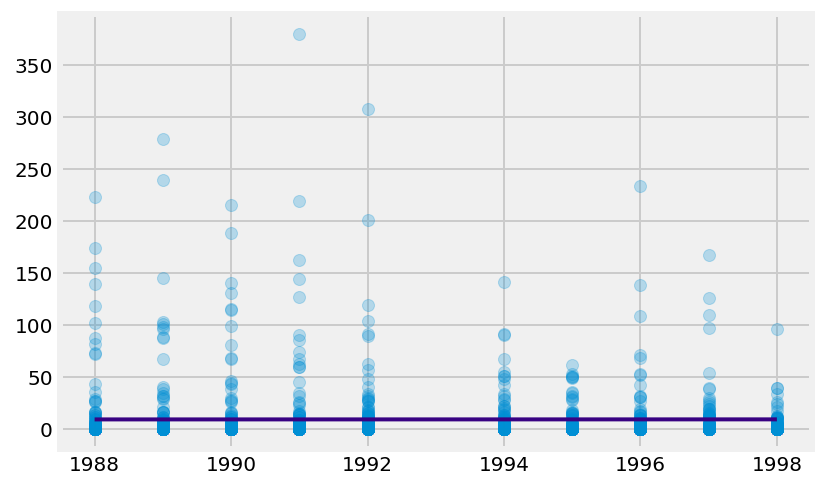

In [274]:
plt.scatter(scatter_df['iyear'], scatter_df['value'], alpha=0.25)

plt.plot(scatter_df['iyear'].values,
        map_estimate['intercept'] + (scatter_df['iyear'] * map_estimate['bominb_beta']),
        c='xkcd:indigo', lw=2)

In [275]:
with reg:
    start = map_estimate
    trace = pm.sample(40000, start=start, njobs=2)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bominb_beta, intercept, bombings_std_log__]
INFO:pymc3:NUTS: [bominb_beta, intercept, bombings_std_log__]
100%|██████████| 40500/40500 [09:17<00:00, 72.70it/s]
The acceptance probability does not match the target. It is 0.8807143851597532, but should be close to 0.8. Try to increase the number of tuning steps.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x120ec1c88>,
      dtype=object)

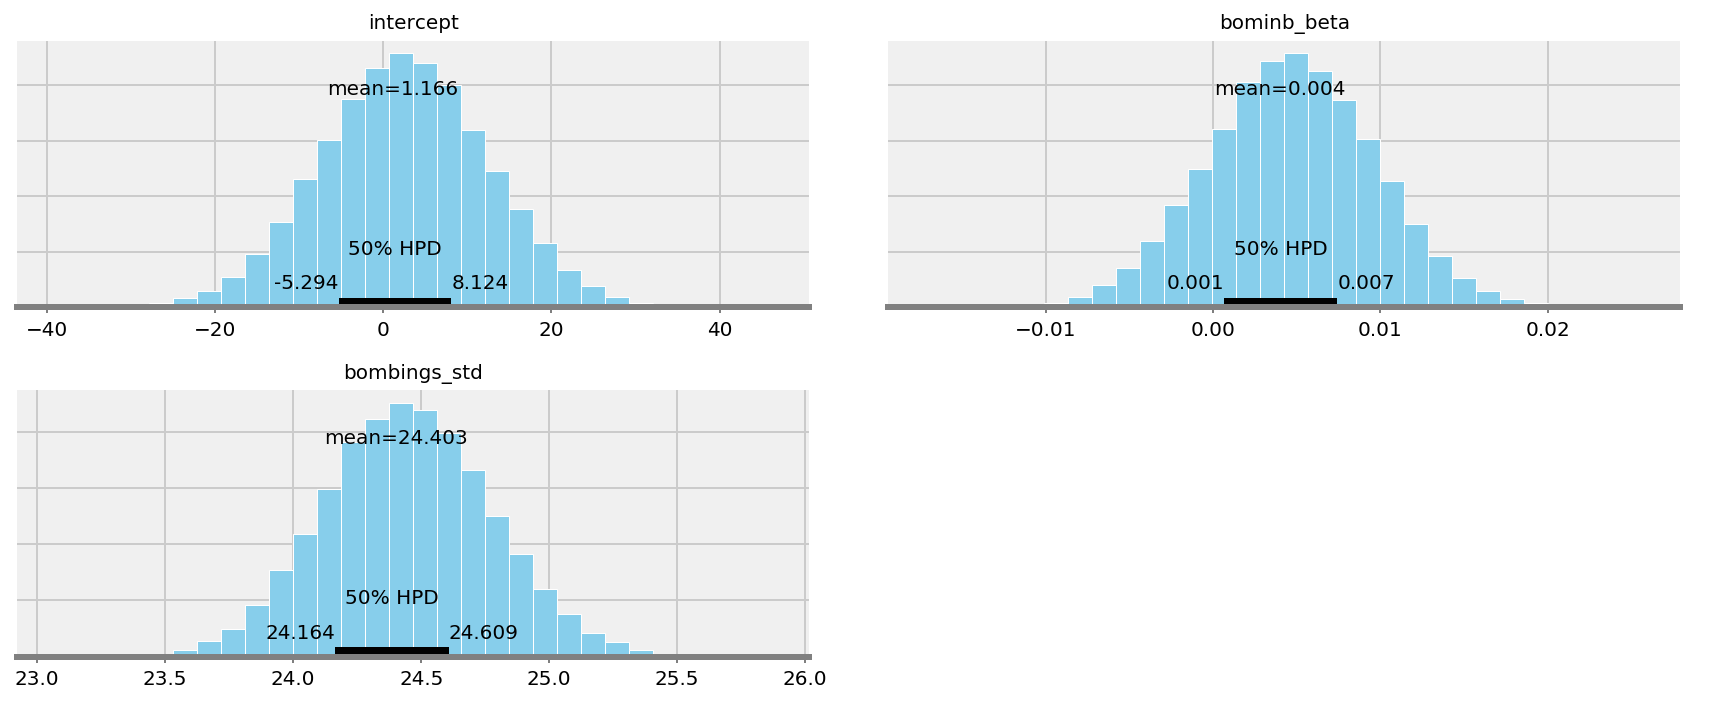

In [276]:
pm.plot_posterior(trace, color='#87ceeb', alpha_level=0.5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14642ab70>,
      dtype=object)

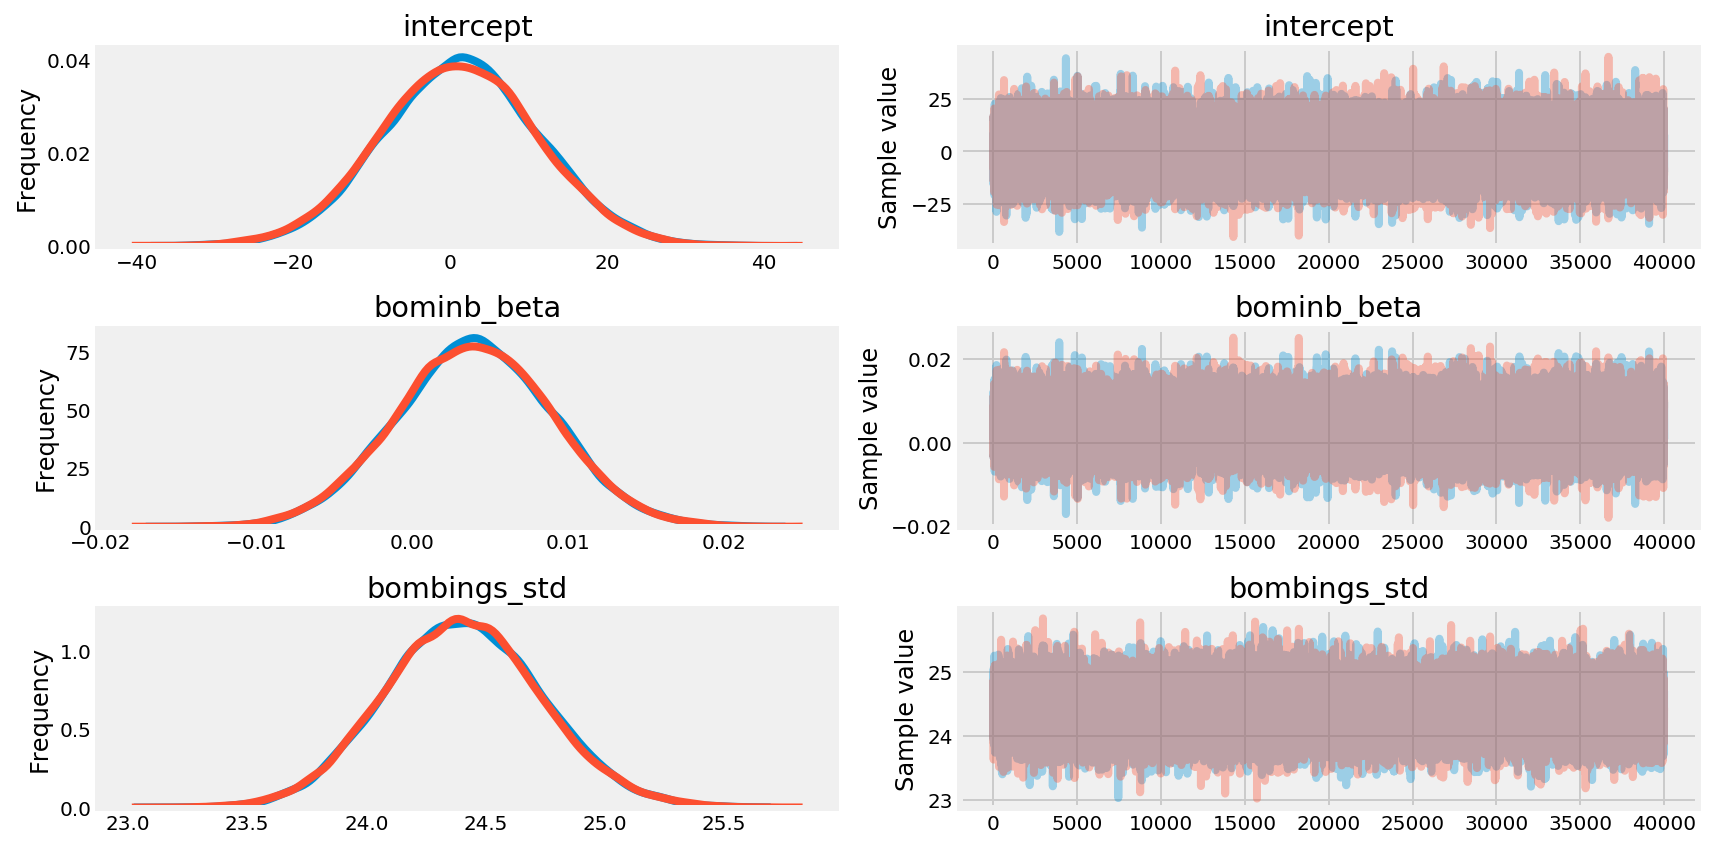

In [277]:
pm.traceplot(trace)

Text(0,0.5,'bombings')

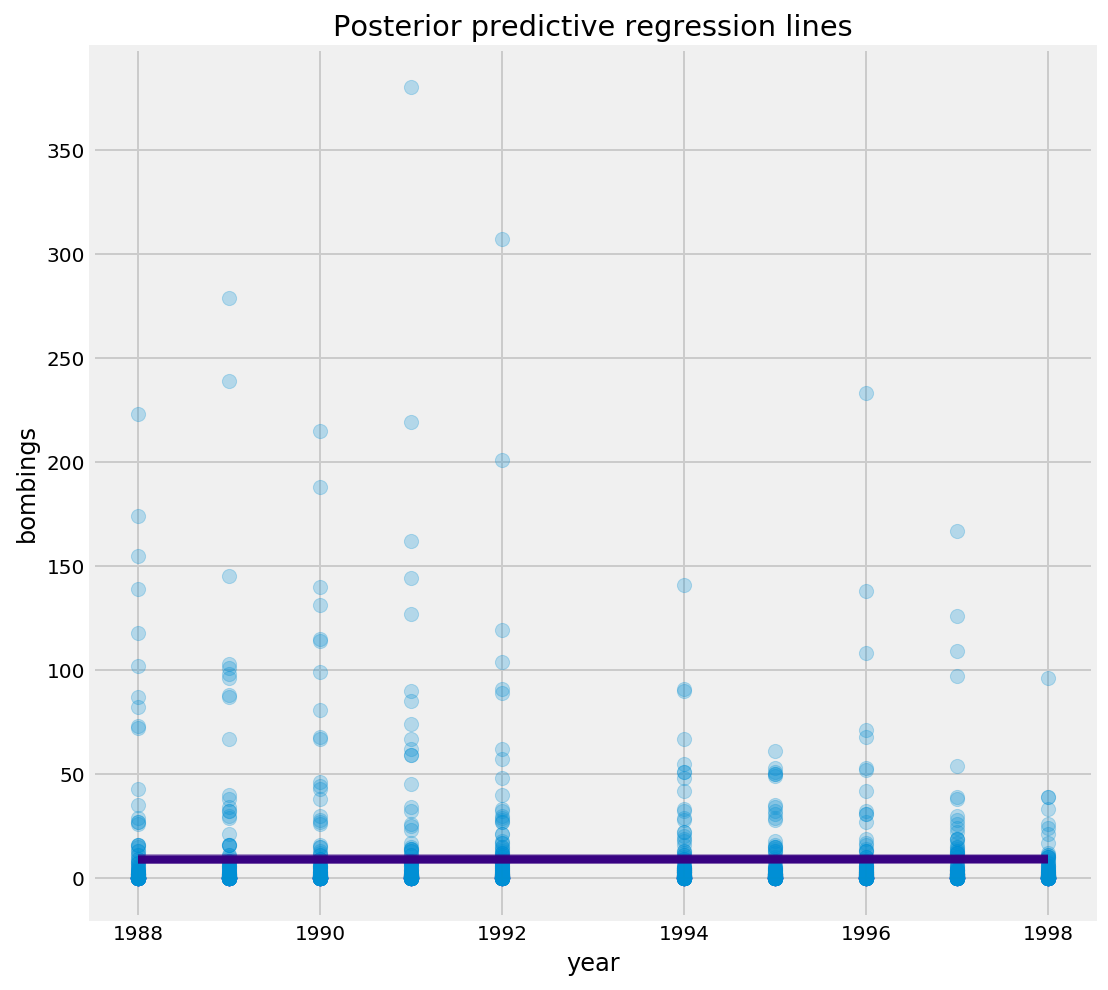

In [278]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(scatter_df['iyear'].values, scatter_df['value'].values,
           s=50, alpha=0.25, label='data')

pm.plot_posterior_predictive_glm(trace, 
                                 samples=1000, 
                                 lm=lambda x, sample: sample['intercept'] + sample['bominb_beta']*x,
                                 eval=scatter_df['iyear'].values,
                                 label='posterior predictive regression lines', color='xkcd:indigo')

plt.title('Posterior predictive regression lines')
plt.xlabel('year')
plt.ylabel('bombings')

In [283]:
# Max Posterior Likelihood
intercept = 1.166
bombing_beta = 0.004

average_bombings_per_country = intercept + (bombing_beta * 1993)

countries_in_dataset = 151

countries_in_dataset * average_bombings_per_country

1379.838

`I predict there was 1380 bombings in 1993`